In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from joblib import dump, load
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [2]:
mlflow.set_tracking_uri("file:///C:/Users/BW/Desktop/ML project/notebook/mlruns")

### **Loading the dataset**

In [3]:
data = pd.read_csv('coffee_shop_revenue.csv')
data.head()

,Number_of_Customers_Per_Day,Average_Order_Value,Operating_Hours_Per_Day,Number_of_Employees,Marketing_Spend_Per_Day,Location_Foot_Traffic,Daily_Revenue
0,152,6.74,14,4,106.62,97,1547.81
1,485,4.50,12,8,57.83,744,2084.68
2,398,9.09,6,6,91.76,636,3118.39
3,320,8.48,17,4,462.63,770,2912.20
4,156,7.44,17,2,412.52,232,1663.42


In [4]:
data.shape

(2000, 7)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Number_of_Customers_Per_Day  2000 non-null   int64  
 1   Average_Order_Value          2000 non-null   float64
 2   Operating_Hours_Per_Day      2000 non-null   int64  
 3   Number_of_Employees          2000 non-null   int64  
 4   Marketing_Spend_Per_Day      2000 non-null   float64
 5   Location_Foot_Traffic        2000 non-null   int64  
 6   Daily_Revenue                2000 non-null   float64
dtypes: float64(3), int64(4)
memory usage: 109.5 KB


In [6]:
data.describe()

,Number_of_Customers_Per_Day,Average_Order_Value,Operating_Hours_Per_Day,Number_of_Employees,Marketing_Spend_Per_Day,Location_Foot_Traffic,Daily_Revenue
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,274.296000,6.261215,11.667000,7.947000,252.614160,534.893500,1917.325940
std,129.441933,2.175832,3.438608,3.742218,141.136004,271.662295,976.202746
min,50.000000,2.500000,6.000000,2.000000,10.120000,50.000000,-58.950000
25%,164.000000,4.410000,9.000000,5.000000,130.125000,302.000000,1140.085000
50%,275.000000,6.300000,12.000000,8.000000,250.995000,540.000000,1770.775000
75%,386.000000,8.120000,15.000000,11.000000,375.352500,767.000000,2530.455000
max,499.000000,10.000000,17.000000,14.000000,499.740000,999.000000,5114.600000


In [7]:
data.isnull().sum()

Number_of_Customers_Per_Day    0
Average_Order_Value            0
Operating_Hours_Per_Day        0
Number_of_Employees            0
Marketing_Spend_Per_Day        0
Location_Foot_Traffic          0
Daily_Revenue                  0
dtype: int64

### **Model training to get baseline metrics**

In [ ]:
models_dict = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "DecisionTreeRegressor": DecisionTreeRegressor(),
    "RandomForestRegressor": RandomForestRegressor(),
    "SVR": SVR(),
    "XGBoostRegressor": XGBRegressor(),
    "KNN": KNeighborsRegressor()
}

def get_baseline_metrics(models_dict, xtrain, ytrain, experiment_name):
    cv_type = KFold(n_splits=5, shuffle=True, random_state=3)
    mlflow.set_experiment(experiment_name)

    for model_name, model in models_dict.items():
        print(f"Training model: {model_name}")
        with mlflow.start_run(run_name=model_name):
            r2_mean = np.mean(cross_val_score(model, xtrain, ytrain, cv=cv_type, scoring='r2'))
            mae_mean = -np.mean(cross_val_score(model, xtrain, ytrain, cv=cv_type, scoring='neg_mean_absolute_error'))
            rmse_mean = -np.mean(cross_val_score(model, xtrain, ytrain, cv=cv_type, scoring='neg_root_mean_squared_error'))

            mlflow.log_param("CV_Type", "KFold")
            mlflow.log_param("CV_n_splits", cv_type.n_splits)
            mlflow.log_param("CV_shuffle", cv_type.shuffle)
            mlflow.log_param("CV_random_state", cv_type.random_state)

            mlflow.log_param("Model_Name", model_name)
            mlflow.log_metric("R2_score", round(r2_mean, 4))
            mlflow.log_metric("MAE", round(mae_mean, 4))
            mlflow.log_metric("RMSE", round(rmse_mean, 4))

            print(f"R2 Score: {r2_mean:.4f}")
            print(f"MAE: {mae_mean:.4f}")
            print(f"RMSE: {rmse_mean:.4f}")
            print('-' * 35)

In [9]:
# Function to get metrics
def get_metrics(ytest, ypred):
    r2 = r2_score(ytest, ypred)
    mae = mean_absolute_error(ytest, ypred)
    rmse = np.sqrt(mean_squared_error(ytest, ypred))
    print(f"R2 score: {r2}")
    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")

In [10]:
# Splitting  the dataset
x = data.drop(columns='Daily_Revenue')
y = data['Daily_Revenue']

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=2)

In [11]:
xtrain.shape

(1600, 6)

### **Getting**

In [12]:
get_baseline_metrics(models_dict, xtrain, ytrain, 'Baseline metrics using Kfold cv (train splits only)')

2025/04/03 11:36:42 INFO mlflow.tracking.fluent: Experiment with name 'Baseline metrics using Kfold cv (train splits only)' does not exist. Creating a new experiment.


Training model: LinearRegression
R2 Score: 0.8899
MAE: 254.3337
RMSE: 322.8229
-----------------------------------
Training model: Ridge
R2 Score: 0.8899
MAE: 254.3352
RMSE: 322.8226
-----------------------------------
Training model: Lasso
R2 Score: 0.8899
MAE: 254.3367
RMSE: 322.8074
-----------------------------------
Training model: ElasticNet
R2 Score: 0.8872
MAE: 257.1948
RMSE: 326.6081
-----------------------------------
Training model: DecisionTreeRegressor
R2 Score: 0.8769
MAE: 275.3707
RMSE: 342.0766
-----------------------------------
Training model: RandomForestRegressor
R2 Score: 0.9412
MAE: 188.2082
RMSE: 234.3118
-----------------------------------
Training model: SVR
R2 Score: 0.0465
MAE: 758.9373
RMSE: 952.5776
-----------------------------------
Training model: XGBoostRegressor
R2 Score: 0.9362
MAE: 195.5885
RMSE: 245.4415
-----------------------------------
Training model: KNN
R2 Score: 0.5278
MAE: 527.6643
RMSE: 668.3486
-----------------------------------


- **From the EDA correlation analysis, only 3 features show good to weak correlation with the target variable. To evaluate potential improvement, models will be tested using only these 3 correlated features while excluding the remaining ones.**

In [13]:
xtrain_dropped_feat = xtrain.drop(columns=['Operating_Hours_Per_Day', 'Location_Foot_Traffic', 'Number_of_Employees'])
xtest_dropped_feat = xtest.drop(columns=['Operating_Hours_Per_Day', 'Location_Foot_Traffic', 'Number_of_Employees'])

In [14]:
xtrain_dropped_feat.head(2)

,Number_of_Customers_Per_Day,Average_Order_Value,Marketing_Spend_Per_Day
333,196,8.56,417.65
721,102,9.89,247.26


In [15]:
xtest_dropped_feat.head(2)

,Number_of_Customers_Per_Day,Average_Order_Value,Marketing_Spend_Per_Day
278,421,6.30,87.03
492,239,4.26,192.94


In [18]:
get_baseline_metrics(models_dict, xtrain_dropped_feat, ytrain, 'Baseline Metrics with Key Features')

2025/04/03 11:41:59 INFO mlflow.tracking.fluent: Experiment with name 'Baseline Metrics with Key Features' does not exist. Creating a new experiment.


Training model: LinearRegression
R2 Score: 0.8904
MAE: 253.8684
RMSE: 322.0398
-----------------------------------
Training model: Ridge
R2 Score: 0.8904
MAE: 253.8697
RMSE: 322.0398
-----------------------------------
Training model: Lasso
R2 Score: 0.8904
MAE: 253.8754
RMSE: 322.0401
-----------------------------------
Training model: ElasticNet
R2 Score: 0.8876
MAE: 256.8567
RMSE: 325.9796
-----------------------------------
Training model: DecisionTreeRegressor
R2 Score: 0.8910
MAE: 257.5377
RMSE: 317.0300
-----------------------------------
Training model: RandomForestRegressor
R2 Score: 0.9439
MAE: 186.4513
RMSE: 232.4030
-----------------------------------
Training model: SVR
R2 Score: 0.1466
MAE: 712.5067
RMSE: 901.1858
-----------------------------------
Training model: XGBoostRegressor
R2 Score: 0.9374
MAE: 195.9694
RMSE: 243.2057
-----------------------------------
Training model: KNN
R2 Score: 0.5432
MAE: 515.5839
RMSE: 656.5906
-----------------------------------


### **Baseline Metrics Analysis**

To assess the impact of feature selection, i compared the baseline metrics before and after dropping three low-correlation features:  
- **Operating_Hours_Per_Day** (-0.0053 correlation)  
- **Number_of_Employees** (0.0033 correlation)  
- **Location_Foot_Traffic** (0.0134 correlation)  

#### **Key Observations:**
**Slight Improvement in Linear Models:**  
- R² for **LinearRegression, Ridge, and Lasso** improved slightly (~0.0005).  
- **MAE and RMSE** slightly decreased, indicating better predictions.  

**DecisionTreeRegressor Performed Better:**  
- R² improved from **0.8769 → 0.8910**, and RMSE decreased.  

**RandomForest and XGBoost Still Strong Performers:**  
- **RandomForest R²:** **0.9412 → 0.9439**  
- **XGBoost R²:** **0.9362 → 0.9374**  
- MAE and RMSE improved slightly.  

**SVR and KNN Still Weak Models:**  
- **SVR improved slightly** but remains ineffective (low R², high MAE).  
- **KNN improved marginally**, but its performance is still subpar.  

#### **Conclusion:**
Removing low-impact features resulted in a **slight performance boost** across most models, particularly **Linear Regression, Decision Tree, and Ensemble Models (Random Forest & XGBoost)**. These results justify **feature selection** as a valuable preprocessing step before model tuning.

## 

In [43]:
xtrain_dropped_feat.head()

,Number_of_Customers_Per_Day,Average_Order_Value,Marketing_Spend_Per_Day
333,196,8.56,417.65
721,102,9.89,247.26
1352,343,6.19,282.79
1680,95,4.17,338.11
156,54,7.80,185.78


In [44]:
xtest_dropped_feat.head()

,Number_of_Customers_Per_Day,Average_Order_Value,Marketing_Spend_Per_Day
278,421,6.30,87.03
492,239,4.26,192.94
1266,467,5.91,127.57
557,434,9.74,359.67
871,466,6.49,133.48


### **Trying to improve linear models(lin reg, l1, l2 and elastic net).**

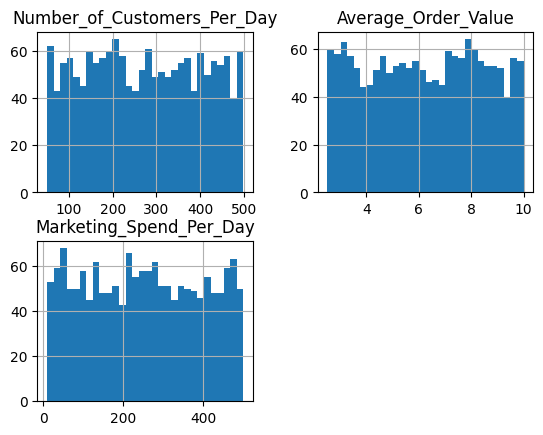

In [ ]:
xtrain_dropped_feat.hist(bins=30)
plt.show()

- Applying log transformation makes the features skewed so transformation step is skipped

In [57]:
# Scaling
std_scaler = StandardScaler()

xtrain_std_scaled = pd.DataFrame(std_scaler.fit_transform(xtrain_dropped_feat), columns=xtrain_dropped_feat.columns)
xtest_std_scaled = pd.DataFrame(std_scaler.transform(xtest_dropped_feat), columns=xtest_dropped_feat.columns)

In [58]:
xtrain_std_scaled.head(2)

,Number_of_Customers_Per_Day,Average_Order_Value,Marketing_Spend_Per_Day
0,-0.594713,1.063727,1.162863
1,-1.317792,1.672344,-0.034669


In [59]:
xtest_std_scaled.head(2)

,Number_of_Customers_Per_Day,Average_Order_Value,Marketing_Spend_Per_Day
0,1.136061,0.029536,-1.160794
1,-0.263943,-0.903982,-0.416440


In [60]:
get_baseline_metrics(models_dict, xtrain_std_scaled, ytrain, 'Key features standard scaled')

2025/04/03 14:35:06 INFO mlflow.tracking.fluent: Experiment with name 'Key features standard scaled' does not exist. Creating a new experiment.


Training model: LinearRegression
R2 Score: 0.8904
MAE: 253.8684
RMSE: 322.0398
-----------------------------------
Training model: Ridge
R2 Score: 0.8904
MAE: 253.8963
RMSE: 322.0385
-----------------------------------
Training model: Lasso
R2 Score: 0.8904
MAE: 253.9198
RMSE: 322.0405
-----------------------------------
Training model: ElasticNet
R2 Score: 0.7931
MAE: 345.2430
RMSE: 443.3665
-----------------------------------
Training model: DecisionTreeRegressor
R2 Score: 0.8937
MAE: 258.5239
RMSE: 315.8263
-----------------------------------
Training model: RandomForestRegressor
R2 Score: 0.9428
MAE: 187.0007
RMSE: 231.7295
-----------------------------------
Training model: SVR
R2 Score: 0.1859
MAE: 689.7025
RMSE: 880.2349
-----------------------------------
Training model: XGBoostRegressor
R2 Score: 0.9374
MAE: 195.9694
RMSE: 243.2057
-----------------------------------
Training model: KNN
R2 Score: 0.9396
MAE: 189.9169
RMSE: 238.3082
-----------------------------------


### **Analysis of Standard Scaling vs. No Scaling Results**

#### **1. Impact on Linear Models (Linear Regression, Ridge, Lasso, ElasticNet)**
- **Linear Regression & Ridge:** No significant change; scaling had no effect.  
- **Lasso:** Slight increase in MAE and RMSE after scaling.  
- **ElasticNet:** Performance dropped significantly (**R²: 0.7931 vs. 0.8876** before scaling), indicating sensitivity to scaling.  

#### **2. Impact on Tree-Based Models (Decision Tree, Random Forest, XGBoost)**
- **DecisionTreeRegressor:** Slight improvement after scaling (**R²: 0.8937 vs. 0.8910**).  
- **RandomForestRegressor & XGBoost:** No significant impact, confirming that tree-based models do not require scaling.  

#### **3. Impact on Distance-Based Models (SVR, KNN)**
- **SVR:** Slight improvement (**R²: 0.1466 → 0.1859**) but still performs poorly.  
- **KNN:** Major improvement (**R²: 0.5432 → 0.9396**), highlighting the importance of scaling for distance-based models.  

### **Conclusion:**
____________________
- **Scaling had minimal impact on linear models but hurt ElasticNet.**  
- **Tree-based models (Decision Tree, Random Forest, XGBoost) do not need scaling.**  
- **Distance-based models (KNN, SVR) benefited from scaling, especially KNN.**  

###  

**                          **

## **Rationale for Hyperparameter Tuning**
____________________________________________________

### **Why Hyperparameter Tune DecisionTree, RandomForest, XGBoost, and KNN?**
- These models have shown **higher performance** than linear models, with **R² > 0.94** in some cases.
- They have multiple hyperparameters that **significantly impact performance** and can be optimized for better results.
- **KNN benefits from standard scaling**, so tuning its hyperparameters (e.g., `n_neighbors`, `weights`, `metric`) can further improve its performance.

### **Why Not Tune Linear Models?**
- **LinearRegression, Ridge, and Lasso** already perform well (**R² ≈ 0.89**).
- Further tuning (e.g., adjusting `alpha` in Ridge/Lasso) is **unlikely to bring substantial improvements**.

### **Why Not Tune SVR?**
- SVR performed **significantly worse** (**R² ≈ 0.18**), indicating it is **not well-suited** for this dataset.
- Tuning its parameters (e.g., `C`, `epsilon`, `kernel`) is unlikely to bridge the performance gap.
- Other models outperform SVR, so focusing on them is a better use of time.

### **Conclusion**
- Decided to proceed with **hyperparameter tuning for DecisionTree, RandomForest, XGBoost, and KNN** to maximize model performance.  
- **Skipping tuning for Linear Models and SVR** due to their **diminishing returns** or poor performance.

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Values (y_test)")
plt.ylabel("Predicted Values (y_pred)")
plt.title("Scatter Plot of Actual vs Predicted Values")
plt.show()

residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.xlabel("Residuals")
plt.title("Residual Distribution (Should Be Normally Distributed)")
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')  # Red line at y=0 for reference
plt.xlabel("Predicted Values (y_pred)")
plt.ylabel("Residuals (y_test - y_pred)")
plt.title("Predicted Values vs Residuals (Should Be Uniformly Scattered)")
plt.show()